In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from promised_land import PromisedLandTrader

# Compare different trading strategies

## Strategy 1 - Koudie

### Inputs

In [3]:
#Read parameters
dict_read_data = {
    "interval":"1d", # Candles of 1 day
    "start_date": "2018-01-01"
                 }

In [4]:
# Signal detection
dict_detect_trades = {
    "rolling_window":6, #Window width in candles of value weighted average price (VWAP)
    "threshold":0.03, #Fraction of deviation from reference metric. (VWAP)
                     }

In [5]:
#Trading amounts
dict_trade_logic = {"initial_investment":100,
                    "trade_fraction_cash":0.2, #Fraction of cash value traded
                    "trade_fraction_volume":0.2, #Fraction of unit volume traded
                   }

## Initialisation

In [6]:
koudie = PromisedLandTrader(dict_read_data=dict_read_data,
                            dict_detect_trades=dict_detect_trades,
                            dict_trade_logic=dict_trade_logic,
                           )

### Performs trades and evaluate strategy

In [7]:
koudie.evalaute_strategy()

Reference metric: vwap - detection threshold: 0.03


### Show strategy performance

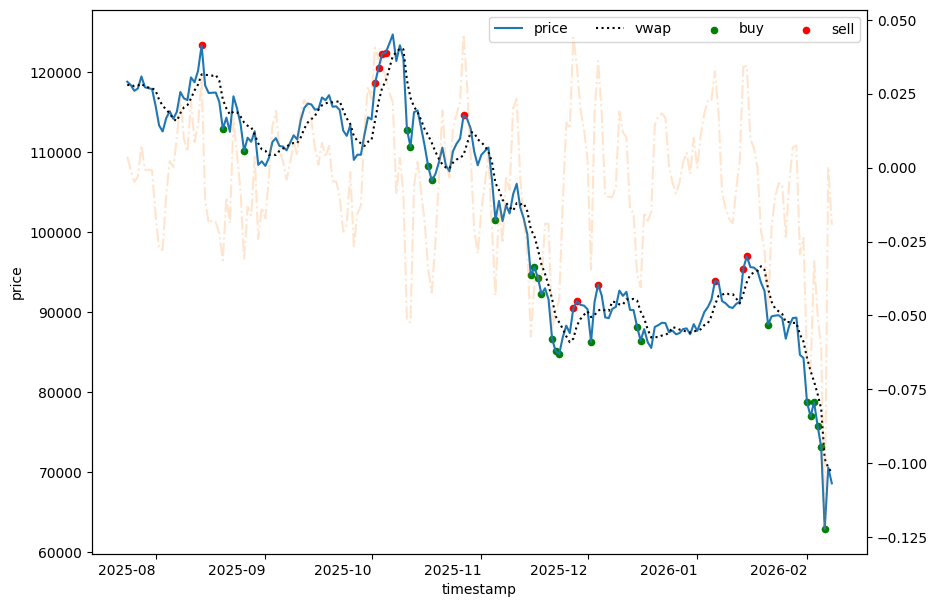

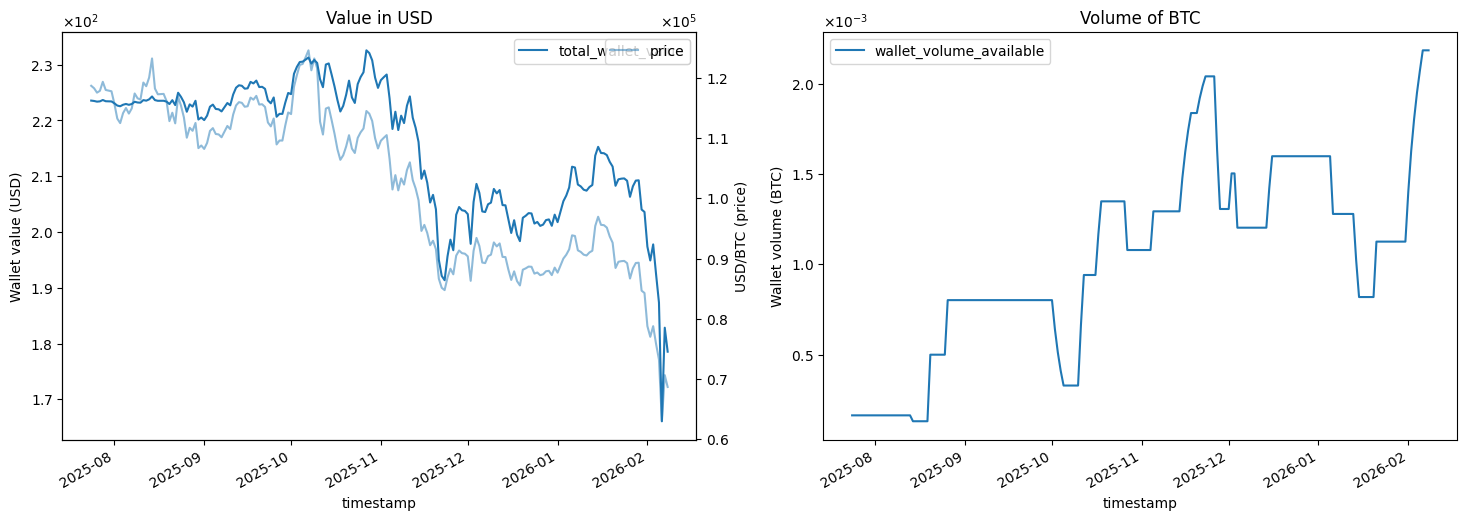

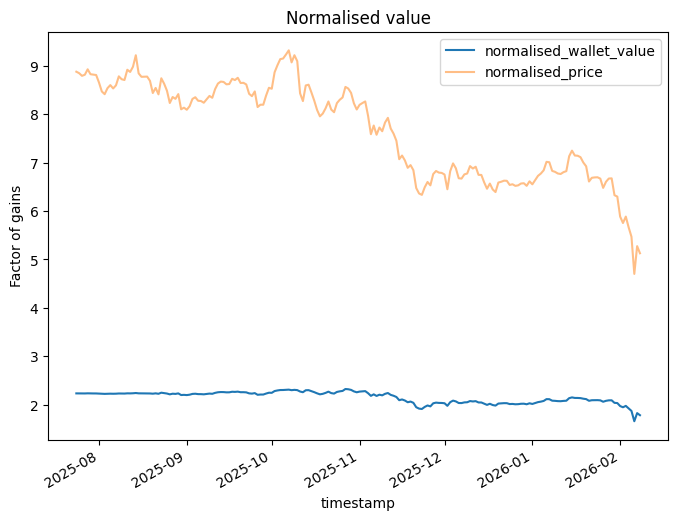

In [9]:
koudie.perform_analysis(sample_size=200)